# Integrate with Torch

Inspiration from https://earthmover.io/blog/cloud-native-dataloader/
But I'm not sure we want to use xbatcher?

### TODO

1. should check that num_surface_vars, num_atmospheric_vars, and num_outputs all makes sense... probably in the sense of the channels... during init?
2. in `__call__`:
    * basically don't need to do anything for inputs to grid node features... probably just the xarray_jax call
    * grid_node_outputs_to_prediction ... just do up to the reshape call
3. `_maybe_init`: just pass lats and lons instead of sample inputs
4. `loss_and_predictions`:
    * could transform to xr.dataarray and then rewrite nothing
    * this would skip over the `level` specific weighting
    * and will have to avoid the `sum_per_variable_losses` since we don't have variables
    * next level of simplicity would be to inflate targets and predictions to their usual sizes and hookup as is. could do this by passing a template to the initialization and just always carry that around... but worry would be that this is somehow problematic
  
...
next up is Bfloat16cast, normalize, and inputsandresiduals

### Deemed out of scope

Here be a list of stuff deemed out of scope while initially figuring this out

1. weighted loss by variable. We will want to just create an array like normalization to be applied, or we could channel idx:val mapping. 
2. 

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader as TorchDataLoader
from xbatcher import BatchGenerator

In [2]:
from simple_emulator import P0Emulator
from p1 import P1Emulator

In [3]:
from graphcast.stacked_graphcast import StackedGraphCast
from graphcast.model_utils import dataset_to_stacked, lat_lon_to_leading_axes

In [4]:
from graphufs.dataset import GraphUFSDataset

## Do the work

Note that `BatchGenerator` should really be a `SampleGenerator` in this case ... it doesn't actually batch things!

In [5]:
p0 = P0Emulator()

In [6]:
%%time
training_data = GraphUFSDataset(p0, mode="training")

CPU times: user 2.34 s, sys: 256 ms, total: 2.59 s
Wall time: 3.01 s


In [7]:
%%time
x,y = training_data[0]

CPU times: user 275 ms, sys: 121 ms, total: 396 ms
Wall time: 440 ms


In [11]:
inputs,targets,forcings = training_data.get_xarrays(0)

In [12]:
import itertools
def product_dict(**kwargs):
    keys = kwargs.keys()
    for instance in itertools.product(*kwargs.values()):
        yield dict(zip(keys, instance))

In [13]:
def get_channel_index(xds, preserved_dims=("batch", "lat", "lon")):

    mapping = {}
    channel = 0
    for varname in sorted(xds.data_vars):
        stacked_dims = list(set(xds[varname].dims) - set(preserved_dims))
        stacked_dims = sorted(
            stacked_dims,
            key=lambda x: list(xds[varname].dims).index(x),
        )
        stacked_dim_dict = {
            k: list(range(len(xds[k])))
            for k in stacked_dims
        }
        for i, selection in enumerate(product_dict(**stacked_dim_dict), start=channel):
            mapping[i] = {"varname": varname, **selection}
        channel = i+1
    return mapping
    

In [32]:
get_channel_index(inputs)

{0: {'varname': 'day_progress_cos', 'time': 0},
 1: {'varname': 'day_progress_cos', 'time': 1},
 2: {'varname': 'day_progress_sin', 'time': 0},
 3: {'varname': 'day_progress_sin', 'time': 1},
 4: {'varname': 'pressfc', 'time': 0},
 5: {'varname': 'pressfc', 'time': 1},
 6: {'varname': 'tmp', 'time': 0, 'level': 0},
 7: {'varname': 'tmp', 'time': 0, 'level': 1},
 8: {'varname': 'tmp', 'time': 0, 'level': 2},
 9: {'varname': 'tmp', 'time': 1, 'level': 0},
 10: {'varname': 'tmp', 'time': 1, 'level': 1},
 11: {'varname': 'tmp', 'time': 1, 'level': 2},
 12: {'varname': 'ugrd10m', 'time': 0},
 13: {'varname': 'ugrd10m', 'time': 1},
 14: {'varname': 'vgrd10m', 'time': 0},
 15: {'varname': 'vgrd10m', 'time': 1},
 16: {'varname': 'year_progress_cos', 'time': 0},
 17: {'varname': 'year_progress_cos', 'time': 1},
 18: {'varname': 'year_progress_sin', 'time': 0},
 19: {'varname': 'year_progress_sin', 'time': 1}}

In [15]:
iidx = get_channel_index(inputs)
tidx = get_channel_index(targets)

In [16]:
mapper = {}
for ti, tval in tidx.items():
    for ii, ival in iidx.items():
        is_match = ival["time"] == len(inputs.time)-1
        
        for k, v in tval.items():
            if k != "time":
                is_match = is_match and v == ival[k]

        if is_match:
            mapper[ti] = ii

In [17]:
mapper

{0: 5, 1: 9, 2: 10, 3: 11, 4: 13, 5: 15}

In [18]:
last_input = x[...,list(mapper.values())]

In [31]:
np.abs((last_input[...,0,2] - inputs.tmp.isel(level=1,time=-1,batch=0)).squeeze()).max()

<xarray.DataArray 'tmp' ()> Size: 8B
array(0.)
Coordinates:
    batch    int64 8B 0
    level    float32 4B 505.7
    time     timedelta64[ns] 8B 00:00:00

In [90]:
get_channel_index(inputs)

{0: {'varname': 'day_progress_cos', 'time': 0},
 1: {'varname': 'day_progress_cos', 'time': 1},
 2: {'varname': 'day_progress_sin', 'time': 0},
 3: {'varname': 'day_progress_sin', 'time': 1},
 4: {'varname': 'pressfc', 'time': 0},
 5: {'varname': 'pressfc', 'time': 1},
 6: {'varname': 'tmp', 'time': 0, 'level': 0},
 7: {'varname': 'tmp', 'time': 0, 'level': 1},
 8: {'varname': 'tmp', 'time': 0, 'level': 2},
 9: {'varname': 'tmp', 'time': 1, 'level': 0},
 10: {'varname': 'tmp', 'time': 1, 'level': 1},
 11: {'varname': 'tmp', 'time': 1, 'level': 2},
 12: {'varname': 'ugrd10m', 'time': 0},
 13: {'varname': 'ugrd10m', 'time': 1},
 14: {'varname': 'vgrd10m', 'time': 0},
 15: {'varname': 'vgrd10m', 'time': 1},
 16: {'varname': 'year_progress_cos', 'time': 0},
 17: {'varname': 'year_progress_cos', 'time': 1},
 18: {'varname': 'year_progress_sin', 'time': 0},
 19: {'varname': 'year_progress_sin', 'time': 1}}

In [62]:
{k: list(inputs[k].values) for k in ["level", "time"]}

{'level': [97.823265, 505.65207, 998.7807],
 'time': [numpy.timedelta64(-21600000000000,'ns'), numpy.timedelta64(0,'ns')]}

In [55]:
inputs

<xarray.Dataset> Size: 4MB
Dimensions:            (batch: 1, time: 2, lat: 192, lon: 384, level: 3)
Coordinates:
  * batch              (batch) int64 8B 0
  * lon                (lon) float64 3kB 0.0 0.9375 1.875 ... 357.2 358.1 359.1
  * lat                (lat) float64 2kB 89.28 88.36 87.42 ... -88.36 -89.28
  * level              (level) float32 12B 97.82 505.7 998.8
  * time               (time) timedelta64[ns] 16B -1 days +18:00:00 00:00:00
Data variables:
    pressfc            (batch, time, lat, lon) float32 590kB 1.038e+05 ... 6....
    ugrd10m            (batch, time, lat, lon) float32 590kB -2.361 ... -3.8
    vgrd10m            (batch, time, lat, lon) float32 590kB -4.973 ... -4.596
    tmp                (batch, time, level, lat, lon) float32 2MB 210.0 ... 2...
    year_progress_cos  (batch, time) float32 8B 1.0 1.0
    day_progress_sin   (batch, time, lon) float32 3kB 0.0 0.01636 ... 0.9999
    year_progress_sin  (batch, time) float32 8B 0.003224 0.007525
    day_progress_cos   (batch, time, lon) float32 3kB 1.0 0.9999 ... 0.01636
Attributes:
    dtp:          720.0
    fhzero:       3
    grid:         gaussian
    grid_id:      1
    im:           384
    imp_physics:  8
    jm:           192
    landsfcmdl:   2
    ncld:         8
    nsoil:        4
    source:       FV3GFS

In [11]:
x.shape

(192, 384, 1, 25)

In [12]:
y.shape

(192, 384, 1, 6)

In [28]:
li = inputs.isel(time=-1, batch=0)

In [29]:
li

<xarray.Dataset> Size: 2MB
Dimensions:            (lat: 192, lon: 384, level: 3)
Coordinates:
    batch              int64 8B 0
  * lon                (lon) float64 3kB 0.0 0.9375 1.875 ... 357.2 358.1 359.1
  * lat                (lat) float64 2kB 89.28 88.36 87.42 ... -88.36 -89.28
  * level              (level) float32 12B 97.82 505.7 998.8
    time               timedelta64[ns] 8B 00:00:00
Data variables:
    pressfc            (lat, lon) float32 295kB 1.038e+05 ... 6.933e+04
    ugrd10m            (lat, lon) float32 295kB -2.248 -2.309 ... -3.883 -3.8
    vgrd10m            (lat, lon) float32 295kB -4.219 -4.185 ... -4.521 -4.596
    tmp                (level, lat, lon) float32 885kB 209.8 209.8 ... 246.6
    year_progress_cos  float32 4B 1.0
    day_progress_cos   (lon) float32 2kB -4.371e-08 -0.01636 ... 0.03272 0.01636
    day_progress_sin   (lon) float32 2kB 1.0 0.9999 0.9995 ... 0.9995 0.9999
    year_progress_sin  float32 4B 0.007525
Attributes:
    dtp:          720.0
    fhzero:       3
    grid:         gaussian
    grid_id:      1
    im:           384
    imp_physics:  8
    jm:           192
    landsfcmdl:   2
    ncld:         8
    nsoil:        4
    source:       FV3GFS

In [ ]:
loc = {
    "pressfc": 5,
    "tmp0": 9,
    "tmp1": 10,
    "tmp2": 11,
    "ugrd10m": 13,
    "vgrd10m": 15,
}

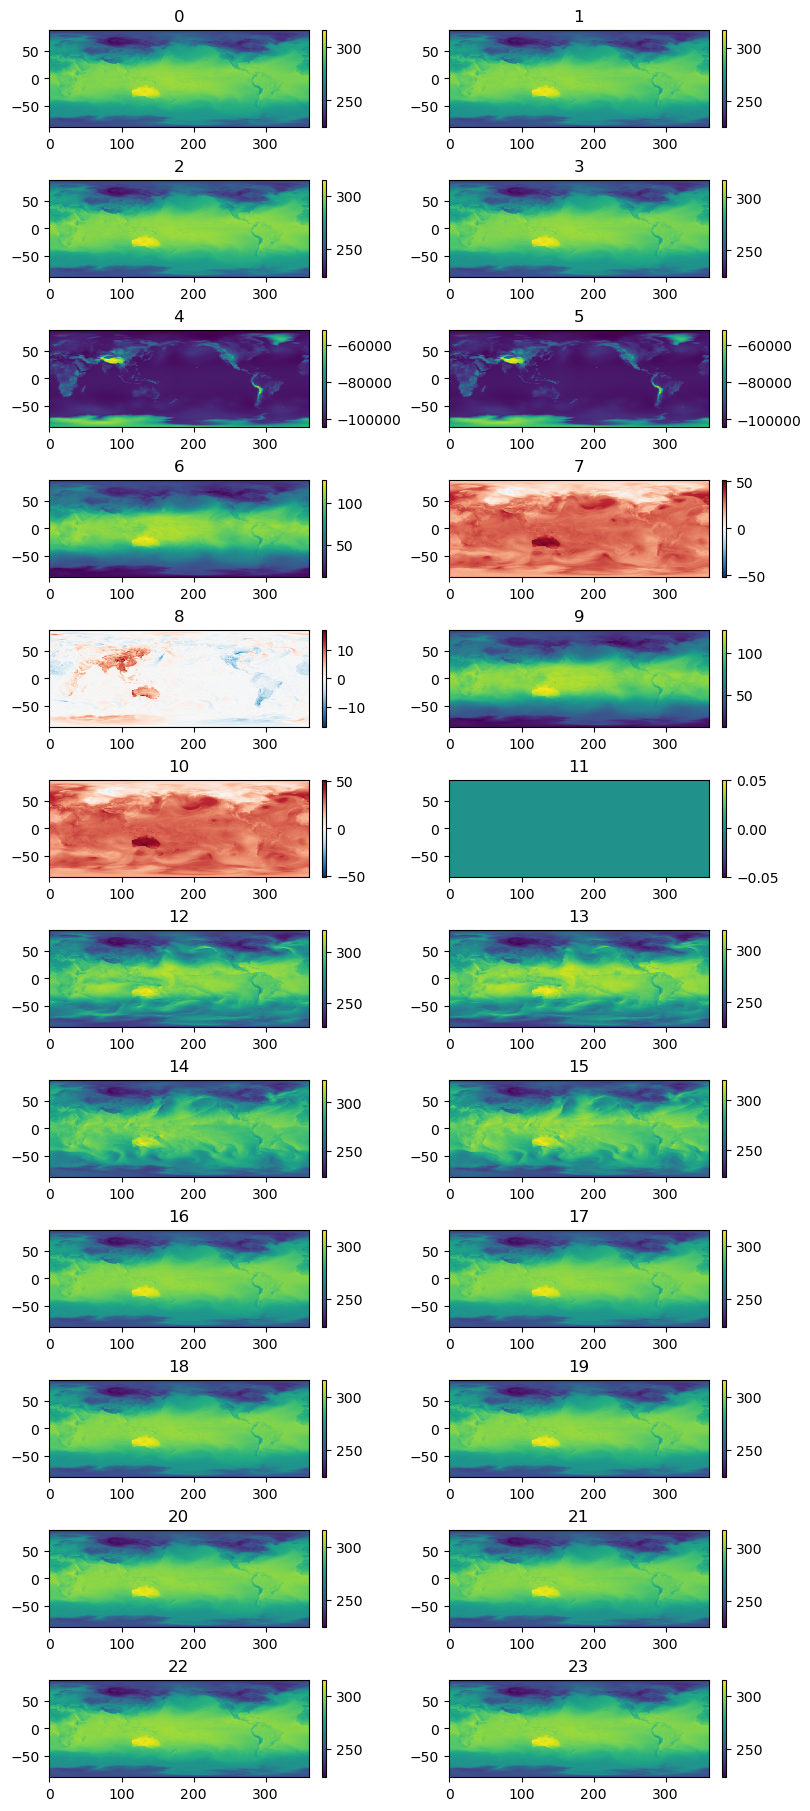

In [56]:
fig, axs = plt.subplots(12, 2, constrained_layout=True, figsize=(8, 18))

fld = "tmp"
for i, ax in enumerate(axs.flatten()):
    (li[fld].isel(level=2) - xi[..., i]).plot(ax=ax, cbar_kwargs={"label": ""})
    ax.set(xlabel="", ylabel="", title=f"{i}")

In [47]:
import haiku as hk
import jax
from graphcast.graphcast import GraphCast

In [48]:
@hk.transform_with_state
def run_original(emulator, inputs, targets, forcings):
    predictor = GraphCast(emulator.model_config, emulator.task_config)
    return predictor(inputs, targets, forcings)

In [49]:
init2 = jax.jit(run_original.init)

In [50]:
params_og, state_og = init2(
    rng=jax.random.PRNGKey(0),
    emulator=p0,
    inputs=inputs,
    targets=targets,
    forcings=forcings,
)

In [51]:
gc = jax.jit(run_original.apply)

In [52]:
expected, _ = gc(
    rng=jax.random.PRNGKey(0),
    emulator=p0,
    inputs=inputs,
    targets=targets,
    forcings=forcings,
    params=params_og,
    state=state_og,
)
expected = dataset_to_stacked(expected)
expected = lat_lon_to_leading_axes(expected)
expected = expected.squeeze()

In [53]:
@hk.transform_with_state
def run_forward(emulator, x_i):
    predictor = StackedGraphCast(emulator.model_config, emulator.task_config)
    return predictor(x_i)

In [54]:
init = jax.jit(run_forward.init)

In [55]:
params, state = init(
    rng=jax.random.PRNGKey(0),
    emulator=p0,
    x_i=x,
)

In [56]:
f = jax.jit(run_forward.apply)

In [57]:
test, _ = f(emulator=p0, x_i=x, params=params, state=state, rng=jax.random.PRNGKey(0))
test = test.squeeze()

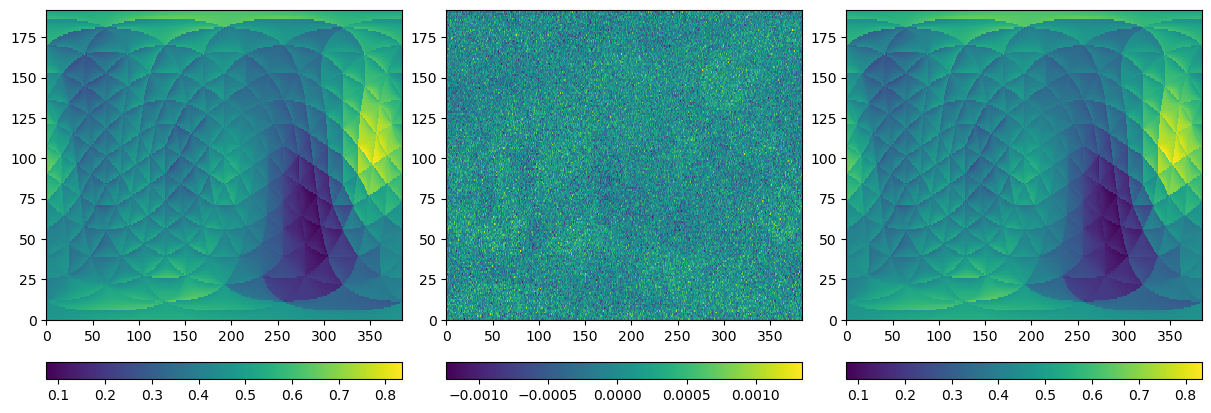

In [58]:
fig, axs = plt.subplots(1,3, figsize=(12, 4), constrained_layout=True)

ii = 4
p = axs[0].pcolormesh(test[:,:,ii])
plt.colorbar(p, ax=axs[0],orientation="horizontal")
p = axs[1].pcolormesh(test[:,:,ii] - expected[..., ii])
plt.colorbar(p, ax=axs[1],orientation="horizontal")
p = axs[2].pcolormesh(expected[...,ii])
plt.colorbar(p, ax=axs[2],orientation="horizontal")

In [59]:
(np.abs(test - expected)/np.abs(expected)).max().values

array(24.030409, dtype=float32)

In [60]:
(np.abs(test - expected)).max().values

array(0.00167727, dtype=float32)

In [18]:
si = s["inputs"]

In [19]:
from graphcast.model_utils import stacked_to_dataset, dataset_to_stacked
from graphufs.utils import normalization_to_stacked

In [20]:
m = p0.norm["mean"]

In [21]:
m

<xarray.Dataset> Size: 72B
Dimensions:            (level: 3)
Coordinates:
  * level              (level) float32 12B 97.82 505.7 998.8
Data variables:
    year_progress_cos  float64 8B 0.01172
    pressfc            float32 4B 9.667e+04
    tmp                (level) float32 12B 207.9 252.1 278.6
    vgrd10m            float32 4B 0.1846
    year_progress_sin  float64 8B -0.001923
    day_progress_sin   float64 8B -1.023e-08
    land               float32 4B 0.6985
    day_progress_cos   float64 8B 2.679e-08
    ugrd10m            float32 4B -0.03665

In [22]:
sm = normalization_to_stacked(p0, m, preserved_dims=())

In [23]:
sm

<xarray.DataArray (channels: 15)> Size: 120B
array([ 2.67949266e-08, -1.02316133e-08,  9.66684609e+04,  2.07933472e+02,
        2.52135315e+02,  2.78622650e+02, -3.66467498e-02,  1.84575677e-01,
        1.17212740e-02, -1.92328226e-03,  2.67949266e-08, -1.02316133e-08,
        6.98509097e-01,  1.17212740e-02, -1.92328226e-03])
Dimensions without coordinates: channels

In [24]:
ssi = dataset_to_stacked(si, preserved_dims=("time", "lat", "lon"))

In [25]:
p0.task_config.input_variables

('pressfc',
 'ugrd10m',
 'vgrd10m',
 'tmp',
 'year_progress_sin',
 'year_progress_cos',
 'day_progress_sin',
 'day_progress_cos')

In [26]:
ssi

<xarray.DataArray (time: 2, lat: 192, lon: 384, channels: 10)> Size: 6MB
array([[[[-1.00000000e+00, -8.74227766e-08,  1.03288617e+05, ...,
          -3.53801560e+00,  9.24799800e-01,  3.80454123e-01],
         [-9.99866128e-01, -1.63620245e-02,  1.03287914e+05, ...,
          -3.47437239e+00,  9.24799800e-01,  3.80454123e-01],
         [-9.99464571e-01, -3.27191018e-02,  1.03287203e+05, ...,
          -3.40974498e+00,  9.24799800e-01,  3.80454123e-01],
         ...,
         [-9.98795450e-01,  4.90674898e-02,  1.03291070e+05, ...,
          -3.72292423e+00,  9.24799800e-01,  3.80454123e-01],
         [-9.99464571e-01,  3.27191688e-02,  1.03290234e+05, ...,
          -3.66230249e+00,  9.24799800e-01,  3.80454123e-01],
         [-9.99866128e-01,  1.63616110e-02,  1.03289391e+05, ...,
          -3.60066247e+00,  9.24799800e-01,  3.80454123e-01]],

        [[-1.00000000e+00, -8.74227766e-08,  1.03066438e+05, ...,
          -3.86410904e+00,  9.24799800e-01,  3.80454123e-01],
         [-9.99866128e-01, -1.63620245e-02,  1.03065023e+05, ...,
          -3.81059551e+00,  9.24799800e-01,  3.80454123e-01],
         [-9.99464571e-01, -3.27191018e-02,  1.03063734e+05, ...,
          -3.75581288e+00,  9.24799800e-01,  3.80454123e-01],
...
           1.41469872e+00,  9.23155010e-01,  3.84427905e-01],
         [-3.27190049e-02, -9.99464571e-01,  7.03043125e+04, ...,
           1.34412932e+00,  9.23155010e-01,  3.84427905e-01],
         [-1.63619258e-02, -9.99866128e-01,  7.02729141e+04, ...,
           1.27389371e+00,  9.23155010e-01,  3.84427905e-01]],

        [[ 1.19248806e-08, -1.00000000e+00,  6.93757344e+04, ...,
           7.07737386e-01,  9.23155010e-01,  3.84427905e-01],
         [ 1.63619481e-02, -9.99866128e-01,  6.93617578e+04, ...,
           6.45593286e-01,  9.23155010e-01,  3.84427905e-01],
         [ 3.27190273e-02, -9.99464571e-01,  6.93475859e+04, ...,
           5.83316505e-01,  9.23155010e-01,  3.84427905e-01],
         ...,
         [-4.90673259e-02, -9.98795450e-01,  6.94166406e+04, ...,
           8.93158257e-01,  9.23155010e-01,  3.84427905e-01],
         [-3.27190049e-02, -9.99464571e-01,  6.94031719e+04, ...,
           8.31541300e-01,  9.23155010e-01,  3.84427905e-01],
         [-1.63619258e-02, -9.99866128e-01,  6.93895312e+04, ...,
           7.69727170e-01,  9.23155010e-01,  3.84427905e-01]]]],
      dtype=float32)
Coordinates:
  * lon      (lon) float64 3kB 0.0 0.9375 1.875 2.812 ... 357.2 358.1 359.1
  * lat      (lat) float64 2kB 89.28 88.36 87.42 86.49 ... -87.42 -88.36 -89.28
  * time     (time) timedelta64[ns] 16B -1 days +18:00:00 00:00:00
Dimensions without coordinates: channels

In [27]:
ssf = dataset_to_stacked(s["forcings"], preserved_dims=("time", "lat", "lon"))

In [28]:
ssi

<xarray.DataArray (time: 2, lat: 192, lon: 384, channels: 10)> Size: 6MB
array([[[[-1.00000000e+00, -8.74227766e-08,  1.03288617e+05, ...,
          -3.53801560e+00,  9.24799800e-01,  3.80454123e-01],
         [-9.99866128e-01, -1.63620245e-02,  1.03287914e+05, ...,
          -3.47437239e+00,  9.24799800e-01,  3.80454123e-01],
         [-9.99464571e-01, -3.27191018e-02,  1.03287203e+05, ...,
          -3.40974498e+00,  9.24799800e-01,  3.80454123e-01],
         ...,
         [-9.98795450e-01,  4.90674898e-02,  1.03291070e+05, ...,
          -3.72292423e+00,  9.24799800e-01,  3.80454123e-01],
         [-9.99464571e-01,  3.27191688e-02,  1.03290234e+05, ...,
          -3.66230249e+00,  9.24799800e-01,  3.80454123e-01],
         [-9.99866128e-01,  1.63616110e-02,  1.03289391e+05, ...,
          -3.60066247e+00,  9.24799800e-01,  3.80454123e-01]],

        [[-1.00000000e+00, -8.74227766e-08,  1.03066438e+05, ...,
          -3.86410904e+00,  9.24799800e-01,  3.80454123e-01],
         [-9.99866128e-01, -1.63620245e-02,  1.03065023e+05, ...,
          -3.81059551e+00,  9.24799800e-01,  3.80454123e-01],
         [-9.99464571e-01, -3.27191018e-02,  1.03063734e+05, ...,
          -3.75581288e+00,  9.24799800e-01,  3.80454123e-01],
...
           1.41469872e+00,  9.23155010e-01,  3.84427905e-01],
         [-3.27190049e-02, -9.99464571e-01,  7.03043125e+04, ...,
           1.34412932e+00,  9.23155010e-01,  3.84427905e-01],
         [-1.63619258e-02, -9.99866128e-01,  7.02729141e+04, ...,
           1.27389371e+00,  9.23155010e-01,  3.84427905e-01]],

        [[ 1.19248806e-08, -1.00000000e+00,  6.93757344e+04, ...,
           7.07737386e-01,  9.23155010e-01,  3.84427905e-01],
         [ 1.63619481e-02, -9.99866128e-01,  6.93617578e+04, ...,
           6.45593286e-01,  9.23155010e-01,  3.84427905e-01],
         [ 3.27190273e-02, -9.99464571e-01,  6.93475859e+04, ...,
           5.83316505e-01,  9.23155010e-01,  3.84427905e-01],
         ...,
         [-4.90673259e-02, -9.98795450e-01,  6.94166406e+04, ...,
           8.93158257e-01,  9.23155010e-01,  3.84427905e-01],
         [-3.27190049e-02, -9.99464571e-01,  6.94031719e+04, ...,
           8.31541300e-01,  9.23155010e-01,  3.84427905e-01],
         [-1.63619258e-02, -9.99866128e-01,  6.93895312e+04, ...,
           7.69727170e-01,  9.23155010e-01,  3.84427905e-01]]]],
      dtype=float32)
Coordinates:
  * lon      (lon) float64 3kB 0.0 0.9375 1.875 2.812 ... 357.2 358.1 359.1
  * lat      (lat) float64 2kB 89.28 88.36 87.42 86.49 ... -87.42 -88.36 -89.28
  * time     (time) timedelta64[ns] 16B -1 days +18:00:00 00:00:00
Dimensions without coordinates: channels

In [29]:
ssf

<xarray.DataArray (time: 1, lat: 192, lon: 384, channels: 5)> Size: 1MB
array([[[[ 1.        ,  0.        ,  2.        ,  0.9214932 ,
           0.38839453],
         [ 0.9998661 ,  0.01636173,  2.        ,  0.9214932 ,
           0.38839453],
         [ 0.9994646 ,  0.03271908,  2.        ,  0.9214932 ,
           0.38839453],
         ...,
         [ 0.99879545, -0.04906764,  2.        ,  0.9214932 ,
           0.38839453],
         [ 0.9994646 , -0.03271884,  2.        ,  0.9214932 ,
           0.38839453],
         [ 0.9998661 , -0.01636176,  2.        ,  0.9214932 ,
           0.38839453]],

        [[ 1.        ,  0.        ,  2.        ,  0.9214932 ,
           0.38839453],
         [ 0.9998661 ,  0.01636173,  2.        ,  0.9214932 ,
           0.38839453],
         [ 0.9994646 ,  0.03271908,  2.        ,  0.9214932 ,
           0.38839453],
...
         [ 0.99879545, -0.04906764,  1.        ,  0.9214932 ,
           0.38839453],
         [ 0.9994646 , -0.03271884,  1.        ,  0.9214932 ,
           0.38839453],
         [ 0.9998661 , -0.01636176,  1.        ,  0.9214932 ,
           0.38839453]],

        [[ 1.        ,  0.        ,  1.        ,  0.9214932 ,
           0.38839453],
         [ 0.9998661 ,  0.01636173,  1.        ,  0.9214932 ,
           0.38839453],
         [ 0.9994646 ,  0.03271908,  1.        ,  0.9214932 ,
           0.38839453],
         ...,
         [ 0.99879545, -0.04906764,  1.        ,  0.9214932 ,
           0.38839453],
         [ 0.9994646 , -0.03271884,  1.        ,  0.9214932 ,
           0.38839453],
         [ 0.9998661 , -0.01636176,  1.        ,  0.9214932 ,
           0.38839453]]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 3kB 0.0 0.9375 1.875 2.812 ... 357.2 358.1 359.1
  * lat      (lat) float64 2kB 89.28 88.36 87.42 86.49 ... -87.42 -88.36 -89.28
  * time     (time) timedelta64[ns] 8B 06:00:00
Dimensions without coordinates: channels

In [30]:
ssif = xr.concat([ssi, ssf], dim="channels")

In [32]:
test = ssif - sm

In [35]:
expected_ssi = dataset_to_stacked(s["inputs"] - m, preserved_dims=("time", "lat", "lon"))
expected_ssf = dataset_to_stacked(s["forcings"] - m, preserved_dims=("time", "lat", "lon"))

expected = xr.concat([expected_ssi, expected_ssf], dim="channels")

In [38]:
expected.max().values

array(7791.578125)

In [40]:
(np.abs(expected - test)/np.abs(expected)).max().values

array(5.96034369e-08)

In [ ]:
a = s

In [ ]:
expected = 

In [ ]:
ssif

In [ ]:
sm

In [27]:
p0.all_variables

('day_progress_sin',
 'vgrd10m',
 'ugrd10m',
 'pressfc',
 'year_progress_cos',
 'day_progress_cos',
 'year_progress_sin',
 'tmp',
 'land')

In [26]:
m

<xarray.Dataset> Size: 88B
Dimensions:            (level: 3)
Coordinates:
  * level              (level) float32 12B 97.82 505.7 998.8
Data variables:
    vgrd10m            float32 4B 0.1846
    ugrd10m            float32 4B -0.03665
    pressfc            float32 4B 9.667e+04
    tmp                (level) float32 12B 207.9 252.1 278.6
    land               float32 4B 0.6985
    year_progress      float64 8B 0.4998
    year_progress_sin  float64 8B -0.001923
    year_progress_cos  float64 8B 0.01172
    day_progress       float64 8B 0.4986
    day_progress_sin   float64 8B -1.023e-08
    day_progress_cos   float64 8B 2.679e-08

In [39]:
p0.norm["mean"]

<xarray.Dataset> Size: 1kB
Dimensions:            (level: 127)
Coordinates:
  * level              (level) float32 508B 0.01278 0.02033 ... 996.2 998.8
Data variables:
    land               float32 4B 0.6985
    pressfc            float32 4B 9.667e+04
    tmp                (level) float32 508B 190.0 193.7 198.4 ... 278.5 278.6
    ugrd10m            float32 4B -0.03665
    vgrd10m            float32 4B 0.1846
    year_progress      float64 8B 0.4998
    year_progress_sin  float64 8B -0.001923
    year_progress_cos  float64 8B 0.01172
    day_progress       float64 8B 0.4986
    day_progress_sin   float64 8B -1.023e-08
    day_progress_cos   float64 8B 2.679e-08

In [43]:
from jax.tree_util import tree_map
from torch.utils.data import default_collate

In [47]:
def xarray_collate(batch):
    return tree_map(xr.Dataset, default_collate(batch))

In [48]:
training_loader = TorchDataLoader(training_data, batch_size=4, collate_fn=xarray_collate)

In [49]:
%%time
i,t,f = next(iter(training_loader))

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'xarray.core.dataarray.DataArray'>

In [11]:
len(training_data) // 16

45

In [36]:
ds = xr.open_zarr(
    "gcs://noaa-ufs-gefsv13replay/ufs-hr1/1.00-degree/03h-freq/zarr/fv3.zarr",
    storage_options={"token": "anon"},
)

In [37]:
ds

<xarray.Dataset> Size: 10TB
Dimensions:        (time: 15916, grid_yt: 192, grid_xt: 384, pfull: 127)
Coordinates:
    cftime         (time) object 127kB dask.array<chunksize=(15916,), meta=np.ndarray>
    ftime          (time) timedelta64[ns] 127kB dask.array<chunksize=(15916,), meta=np.ndarray>
  * grid_xt        (grid_xt) float64 3kB 0.0 0.9375 1.875 ... 357.2 358.1 359.1
  * grid_yt        (grid_yt) float64 2kB 89.28 88.36 87.42 ... -88.36 -89.28
  * pfull          (pfull) float32 508B 0.01278 0.02033 0.03177 ... 996.2 998.8
  * time           (time) datetime64[ns] 127kB 1993-12-31T18:00:00 ... 1999-0...
Data variables: (12/179)
    acond          (time, grid_yt, grid_xt) float32 5GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    albdo_ave      (time, grid_yt, grid_xt) float32 5GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    alnsf          (time, grid_yt, grid_xt) float32 5GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    alnwf          (time, grid_yt, grid_xt) float32 5GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    alvsf          (time, grid_yt, grid_xt) float32 5GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    alvwf          (time, grid_yt, grid_xt) float32 5GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    ...             ...
    xtts           (time, grid_yt, grid_xt) float32 5GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    xu             (time, grid_yt, grid_xt) float32 5GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    xv             (time, grid_yt, grid_xt) float32 5GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    xz             (time, grid_yt, grid_xt) float32 5GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    xzts           (time, grid_yt, grid_xt) float32 5GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    zc             (time, grid_yt, grid_xt) float32 5GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
Attributes:
    dtp:          720.0
    fhzero:       3
    grid:         gaussian
    grid_id:      1
    im:           384
    imp_physics:  8
    jm:           192
    landsfcmdl:   2
    ncld:         8
    nsoil:        4
    source:       FV3GFS

In [11]:
import yaml

In [30]:
lat = list(float(x) for x in ds.grid_yt.values)

In [31]:
with open("lats_quarter_subsampled.yaml", "w") as f:
    yaml.dump(lat, f)

In [32]:
lon = list(float(x) for x in ds.grid_xt.values)

In [33]:
with open("lons_quarter_subsampled.yaml", "w") as f:
    yaml.dump(lon, f)

In [34]:
ds = xr.open_zarr(
    "gcs://noaa-ufs-gefsv13replay/ufs-hr1/0.25-degree/03h-freq/zarr/fv3.zarr",
    storage_options={"token": "anon"},
)

In [35]:
ds

<xarray.Dataset> Size: 901TB
Dimensions:        (time: 87020, grid_yt: 768, grid_xt: 1536, pfull: 127)
Coordinates:
    cftime         (time) object 696kB dask.array<chunksize=(21755,), meta=np.ndarray>
    ftime          (time) timedelta64[ns] 696kB dask.array<chunksize=(21755,), meta=np.ndarray>
  * grid_xt        (grid_xt) float64 12kB 0.0 0.2344 0.4688 ... 359.5 359.8
  * grid_yt        (grid_yt) float64 6kB 89.82 89.59 89.35 ... -89.59 -89.82
  * pfull          (pfull) float32 508B 0.01278 0.02033 0.03177 ... 996.2 998.8
  * time           (time) datetime64[ns] 696kB 1993-12-31T18:00:00 ... 2023-1...
Data variables: (12/179)
    acond          (time, grid_yt, grid_xt) float32 411GB dask.array<chunksize=(1, 768, 1536), meta=np.ndarray>
    albdo_ave      (time, grid_yt, grid_xt) float32 411GB dask.array<chunksize=(1, 768, 1536), meta=np.ndarray>
    alnsf          (time, grid_yt, grid_xt) float32 411GB dask.array<chunksize=(1, 768, 1536), meta=np.ndarray>
    alnwf          (time, grid_yt, grid_xt) float32 411GB dask.array<chunksize=(1, 768, 1536), meta=np.ndarray>
    alvsf          (time, grid_yt, grid_xt) float32 411GB dask.array<chunksize=(1, 768, 1536), meta=np.ndarray>
    alvwf          (time, grid_yt, grid_xt) float32 411GB dask.array<chunksize=(1, 768, 1536), meta=np.ndarray>
    ...             ...
    xtts           (time, grid_yt, grid_xt) float32 411GB dask.array<chunksize=(1, 768, 1536), meta=np.ndarray>
    xu             (time, grid_yt, grid_xt) float32 411GB dask.array<chunksize=(1, 768, 1536), meta=np.ndarray>
    xv             (time, grid_yt, grid_xt) float32 411GB dask.array<chunksize=(1, 768, 1536), meta=np.ndarray>
    xz             (time, grid_yt, grid_xt) float32 411GB dask.array<chunksize=(1, 768, 1536), meta=np.ndarray>
    xzts           (time, grid_yt, grid_xt) float32 411GB dask.array<chunksize=(1, 768, 1536), meta=np.ndarray>
    zc             (time, grid_yt, grid_xt) float32 411GB dask.array<chunksize=(1, 768, 1536), meta=np.ndarray>

In [29]:
ds = xr.open_zarr(
    "gcs://noaa-ufs-gefsv13replay/ufs-hr1/0.25-degree-subsampled/03h-freq/zarr",
    storage_options={"token": "anon"},
)

In [ ]:
# get sample generator



In [ ]:
sgen = BatchGenerator(
    ds=ds,
    